In [16]:
%pylab inline
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline
from numpy.linalg import svd, norm
from mpl_toolkits import mplot3d
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


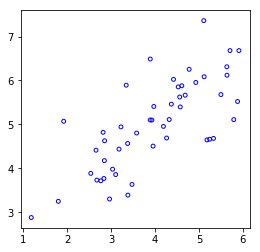

In [17]:
data1 = loadmat("ex7data1.mat")
X = data1['X']

plt.scatter(*X.T, marker='o', edgecolors='b', c='none', s=15);
#plt.grid()
plt.axis('scaled');

### Manual method

(array([1.77094936, 0.26986696]), array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]))

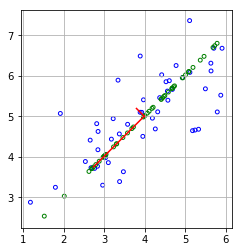

In [19]:
def pca_manual():
    X_mean, X_std =  X.mean(0), X.std(0)
    X_norm = (X - X_mean) / X_std
    X_cov = (X_norm.T @ X_norm) / (X_norm.shape[0] - 1)
    U,S,Vh = svd(X_cov)
    #S,U = eig(X_cov)

    plt.scatter(*X.T, marker='o', edgecolors='b', c='none', s=15);
    plt.plot(*array([X_mean, X_mean + S[0] * U[:,0]]).T, 'r-')
    plt.plot(*array([X_mean, X_mean + S[1] * U[:,1]]).T, 'r-')
    plt.grid()

    k = 1
    U_k = U[:, :k]
    M_std = X_std.reshape(-1,1)@X_std.reshape(-1,1).T
    X_redux = ((X_norm * X_std)  @ U_k @ U_k.T) + X_mean
    plt.scatter(*X_redux.T , marker='o', edgecolors='g', c='none', s=15);
    plt.axis('scaled');
    return S, Vh.T

pca_manual()

### PCA method

**Sklearn PCA** method **mean normalizes** the data, **doesn't scale it by $\sigma$** and only compute **covariance matrix dividing by N-1**!!!

When used after **StandardScaler** in a **Pipeline**, **inverseTransform doesn't perform accurately**.

(array([2.10987818, 0.3135314 ]), array([[-0.76908153, -0.63915068],
        [-0.63915068,  0.76908153]]))

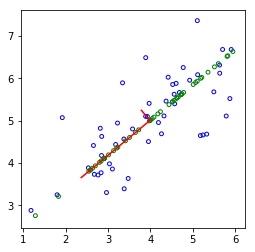

In [20]:
def pca_sklearn():
    pca = PCA()
    pca.fit(X)

    V = pca.components_
    S = pca.explained_variance_
    X_mean = pca.mean_

    plt.scatter(*X.T, marker='o', edgecolors='b', c='none', s=15);
    plt.plot(*array([X_mean, X_mean + S[0] * V[:,0]]).T, 'r-')
    plt.plot(*array([X_mean, X_mean + S[1] * V[:,1]]).T, 'r-')
    plt.xlim(0,8)
    plt.ylim(2,8)
    
    pca.set_params(n_components=1)
    pca.fit(X)
    X_redux = pca.transform(X)

    plt.scatter(*(pca.inverse_transform(X_redux)).T, marker='o', edgecolors='g', c='none', s=15);
    plt.axis('scaled');
    return S, V

pca_sklearn()

### Image Dimensionality Reduction

In [5]:
faces = loadmat('ex7faces.mat')
X_faces = faces['X']

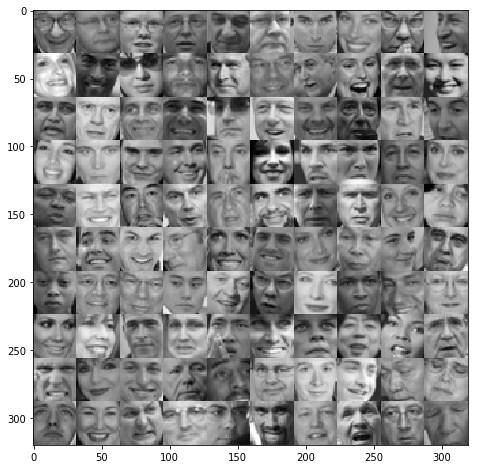

In [6]:
def display_faces():
    X_display = X_faces[:100].reshape(10,10,32,32).transpose(0,3,1,2).reshape(320,320)
    figure(figsize=(8,8))
    imshow(X_display, cmap='gray');
    
display_faces()

0.9328617659663597
[0.30274785 0.43979889 0.50608583 ... 0.99999962 0.99999981 1.        ]


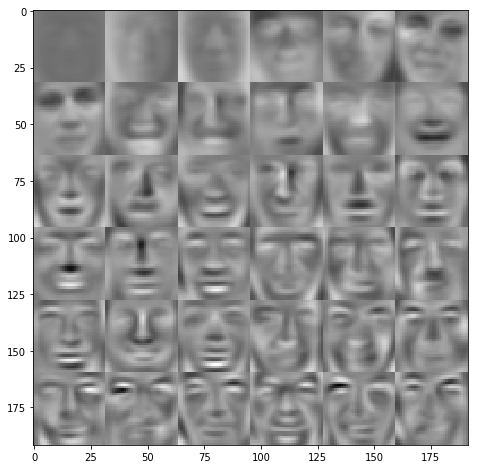

In [7]:
def display_pc_sklearn():
    pca = PCA().fit(X_faces)
    V = pca.components_
    comp = V[:36].reshape(6,6,32,32).transpose(0,3,1,2).reshape(192,192)
    figure(figsize=(8,8))
    imshow(comp, cmap='gray');
    print(sum(pca.explained_variance_[:100])/sum(pca.explained_variance_))
    print(pca.explained_variance_ratio_.cumsum())

display_pc_sklearn()

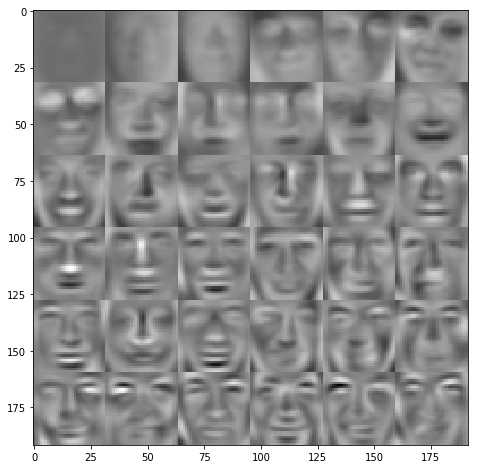

In [8]:
def display_pc_manual():
    X_mean, X_std = X_faces.mean(0), X_faces.std(0)
    X_norm = (X_faces - X_mean)# / X_std
    X_cov = (X_norm.T@X_norm) / (X_norm.shape[0] - 1)
    U,S,Vh = svd(X_cov)
    comp = Vh[:36].reshape(6,6,32,32).transpose(0,3,1,2).reshape(192,192)
    figure(figsize=(8,8))
    imshow(comp, cmap='gray');

display_pc_manual()

### Data Reconstruction

In [9]:
@widgets.interact(retained_variance=widgets.FloatSlider(value=0.935, min=0.01, max=1, step=0.01))
def reconstruct_sklearn(retained_variance):
    pca = PCA(retained_variance, svd_solver='full').fit(X_faces)
    X_reduced = pca.inverse_transform(pca.transform(X_faces))
    X_display = X_reduced[:100].reshape(10,10,32,32).transpose(0,3,1,2).reshape(320,320)
    figure(figsize=(8,8))
    imshow(X_display, cmap='gray');
    print(pca.n_components_)

interactive(children=(FloatSlider(value=0.935, description='retained_variance', max=1.0, min=0.01, step=0.01),…

In [10]:
@widgets.interact(n_components=widgets.IntSlider(value=100, min=1, max=1024, step=1))
def reconstruct_manual(n_components):
    X_mean, X_std = X_faces.mean(0), X_faces.std(0)
    X_norm = (X_faces - X_mean)# / X_std
    X_cov = (X_norm.T@X_norm) / (X_norm.shape[0] - 1)
    U,S,Vh = svd(X_cov)
    X_reduced = X_faces@Vh[:n_components,:].T@Vh[:n_components,:] + X_mean
    X_display = X_reduced[:100].reshape(10,10,32,32).transpose(0,3,1,2).reshape(320,320)
    figure(figsize=(8,8))
    imshow(X_display, cmap='gray');

interactive(children=(IntSlider(value=100, description='n_components', max=1024, min=1), Output()), _dom_class…

### Retained Variance (Explained Variance)

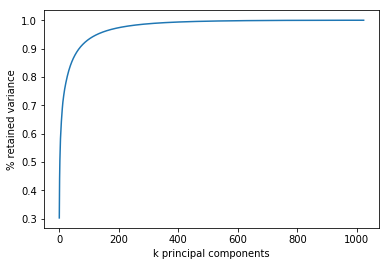

In [11]:
def retained_variance_manual():
    X_mean, X_std = X_faces.mean(0), X_faces.std(0)
    X_norm = (X_faces - X_mean)# / X_std
    X_cov = (X_norm.T@X_norm) / (X_norm.shape[0] - 1)
    U,S,Vh = svd(X_cov)
    rv = cumsum(S/S.sum())
    plt.plot(rv)
    plt.xlabel('k principal components')
    plt.ylabel('% retained variance')
    
retained_variance_manual()

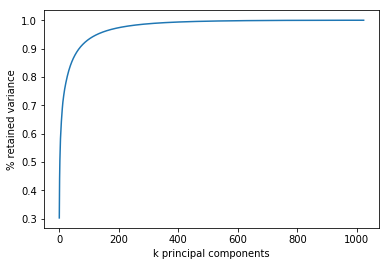

In [12]:
def retained_variance_sklearn():
    pca = PCA().fit(X_faces)
    V = pca.components_
    plt.plot(pca.explained_variance_ratio_.cumsum())
    plt.xlabel('k principal components')
    plt.ylabel('% retained variance')
    
retained_variance_sklearn()

### PCA for Visualization

In [13]:
img_data = imread("bird_small.png")
X_img = img_data.reshape(-1,3)

0.9932492


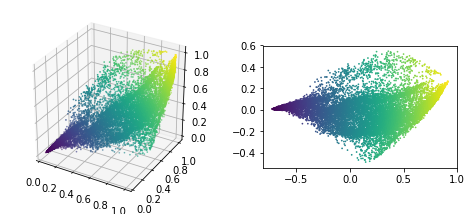

In [14]:
pca = PCA(2).fit(X_img)
X_img_reduced = pca.transform(X_img)

plt.figure(figsize=(8,10))
plt.subplots_adjust(wspace=0.3)
ax1 = plt.subplot(1,2,1, projection='3d')
ax2 = plt.subplot(1,2,2)
ax1.scatter3D(*X_img.T, s=0.5,
              c=norm(X_img, axis=1).T,
              cmap=cm.viridis);
ax1.axis('scaled')
ax2.scatter(*X_img_reduced.T, s=0.5,
            c=norm(X_img, axis=1).T,
            cmap=cm.viridis)
ax2.axis('scaled');

print(pca.explained_variance_ratio_[:2].sum())